<a href="https://colab.research.google.com/github/RobinMikeal/Geol558/blob/main/Module_5_SciKit_Image_Robin_Mikeal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 5:  Scikit-Image
Robin Mikeal
Geol 558, Spring 2025

In [ ]:
#!pip install scikit-image
#!pip install Pillow==9.5.0
#!pip install requests
#!pip install pillow-heif

For this project, I chose to use images from my phone rather than images that I had saved on my computer as a jpg.  These images were HEIC images.  So, I had to install pillow and use the heif opener to open this file format.  I saved the images from my phone to Google Drive, and copied them over to GitHub so that they would be accessible via link.  I added this code into each model, and also made some adjustments to the hyperparameters of the provided code.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from pillow_heif import register_heif_opener
from scipy.signal import convolve2d as conv2
from scipy.ndimage import gaussian_filter
from skimage import (
    color, restoration, img_as_float, io, exposure, data, segmentation, graph
)
from skimage.metrics import structural_similarity as ssim, mean_squared_error
from skimage.morphology import reconstruction
from skimage.util import invert
from skimage.filters import meijering, sato, frangi, hessian
from skimage.exposure import match_histograms

# 1.0 Image Deconvolution
For this model, I chose to evaluate the effect of deconvolution on an underwater image taken in the Cayman Islands.  I was hoping that it would somehow make underwater photos more clear....


SOURCE PROVIDED INFO:

The algorithm is based on a PSF (Point Spread Function),
where PSF is described as the impulse response of the
optical system. The blurred image is sharpened through a number of
iterations, which needs to be hand-tuned.

.. [1] William Hadley Richardson, "Bayesian-Based Iterative
       Method of Image Restoration",
       J. Opt. Soc. Am. A 27, 1593-1607 (1972), :DOI:`10.1364/JOSA.62.000055`

.. [2] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution

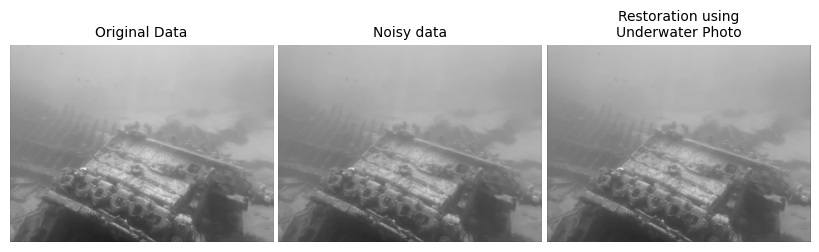

In [ ]:
rng = np.random.default_rng()
rng = np.random.default_rng()

image_url = 'https://github.com/RobinMikeal/Geol558/blob/main/UNDERWATER.HEIC?raw=true'
response = requests.get(image_url)
register_heif_opener() # Register the HEIC opener with Pillow to handle HEIC files
UW = color.rgb2gray(np.array(Image.open(BytesIO(response.content))))

psf = np.ones((5, 5)) / 25
UW = conv2(UW, psf, 'same')
# Add Noise to Image
UW_noisy = UW.copy()
UW_noisy += (rng.poisson(lam=25, size=UW.shape) - 10) / 255.0

# Restore Image using Richardson-Lucy algorithm
deconvolved_UW = restoration.richardson_lucy(UW_noisy, psf, num_iter=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
    a.axis('off')

ax[0].imshow(UW)
ax[0].set_title('Original Data')

ax[1].imshow(UW_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_UW, vmin=UW_noisy.min(), vmax=UW_noisy.max())
ax[2].set_title('Restoration using\nUnderwater Photo')


fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()

So that is basically a fail!  I used a couple of different images on this code, including some that looked "grainy".  But it doesn't make much of an improvement of modern digital pictures, or when the context is too busy.  Overall, it was a bit underwhelming.  

#2.0 Structural similarity index

I was interested to see if this tool would be helpful in outcrops.  I also tried an image a vertical sill, but that was not very promising either.  But this is still a nice image of the Flat Irons last year.  It never gets old.

SOURCE INFO:  When comparing images, the mean squared error (MSE)–while simple to implement–is not highly indicative of perceived similarity. Structural similarity aims to address this shortcoming by taking texture into account [1], [2].

The example shows two modifications of the input image, each with the same MSE, but with very different mean structural similarity indices.

[1]
Zhou Wang; Bovik, A.C.; ,”Mean squared error: Love it or leave it? A new look at Signal Fidelity Measures,” Signal Processing Magazine, IEEE, vol. 26, no. 1, pp. 98-117, Jan. 2009.

[2]
Z. Wang, A. C. Bovik, H. R. Sheikh and E. P. Simoncelli, “Image quality assessment: From error visibility to structural similarity,” IEEE Transactions on Image Processing, vol. 13, no. 4, pp. 600-612, Apr. 2004.



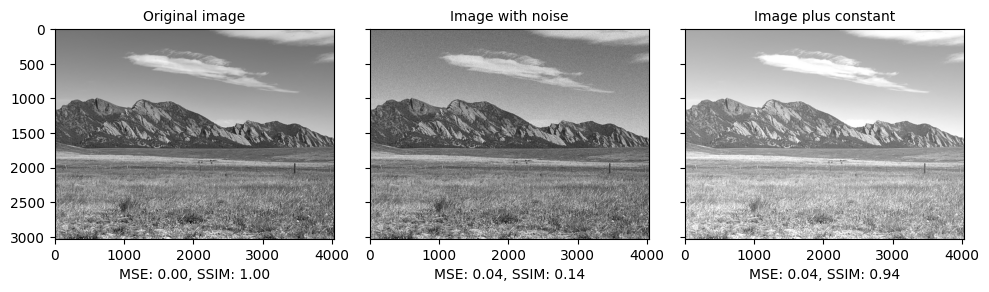

In [ ]:
# Load the HEIC image from Github
image_url = 'https://github.com/RobinMikeal/Geol558/blob/main/IMAGE1.HEIC?raw=true' # Update the image URL to match the one where your HEIC file is located on GitHub
register_heif_opener() # Register the HEIC opener to handle HEIC files
response = requests.get(image_url)
img = img_as_float(np.array(Image.open(BytesIO(response.content)).convert('L'))) # Read the HEIC file and convert it to a grayscale image


rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
rng = np.random.default_rng()
noise[rng.random(size=noise.shape) > 0.5] *= -1

img_noise = img + noise
img_const = img + abs(noise)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

The edge between the front range and the sky stands out a little more.  But I could not decipher much more that this kit achieved.  Overall, it seems like it simply decreased the contrast, and brightened/lightened the image, giving it a more more muted look.  


# 3.0 Filtering regional maxima
I was most excited about this kit.  On my 2nd project I struggled with removing backgrounds of my images.  I think this kit would have been extremely helpful and look forward to trying it within the model that I created for that assignment.  For this test, I used a pic of these butter clam (bivalve shells) picked up along the shore at Wrightsville Beach, NC (which we later used as wedding favors for my daughter's wedding).  But the old paleontologist in me had to document the variation before I gave them out!

SOURCE INFO:  Here, we use morphological reconstruction to create a background image, which
we can subtract from the original image to isolate bright features (regional
maxima).

First we try reconstruction by dilation starting at the edges of the image. We
initialize a seed image to the minimum intensity of the image, and set its
border to be the pixel values in the original image. These maximal pixels will
get dilated in order to reconstruct the background image.


In [ ]:
# Register the HEIC opener with Pillow to handle HEIC files
register_heif_opener()

# Load the HEIC image from Github
image_url = 'https://github.com/RobinMikeal/Geol558/blob/main/IMAGE4.HEIC?raw=true'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)) # Open the image using PIL

# Get image dimensions
width, height = image.size

# Calculate crop dimensions
crop_widthLeft = int(width * 0.10)
crop_widthRight = int(width * 0.15)
crop_height = int(height * 0.25)

# Crop the image
left = crop_widthLeft
upper = crop_height
right = width - crop_widthRight
lower = height - crop_height
image = image.crop((left, upper, right, lower))

# Convert to NumPy array and float
image = img_as_float(np.array(image))

# Convert to float: Important for subtraction later which won't work with uint8
#image = img_as_float(data.coins()) #Commented out to use custom image instead
image = gaussian_filter(image, 1)

# Invert the image
image_inverted = invert(image)

# Apply reconstruction on the inverted image
seed = np.copy(image_inverted)
seed[1:-1, 1:-1] = image_inverted.min()
mask = image_inverted

dilated = reconstruction(seed, mask, method='dilation')

# Invert the result back
isolated_features = invert(dilated - image_inverted)

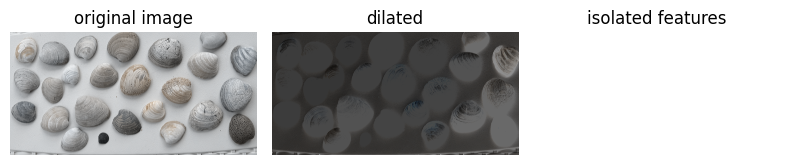

In [ ]:
# Clip the data to the valid range
image_clipped = np.clip(image, 0, 1)
dilated_clipped = np.clip(dilated, image_inverted.min(), image_inverted.max())
isolated_features_clipped = np.clip(isolated_features, 0, 1)

# Create and configure subplots
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True)

# Display the original image
ax0.imshow(image_clipped, cmap='gray', vmin=0, vmax=1)
ax0.set_title('original image')
ax0.axis('off')

# Display the dilated image
ax1.imshow(dilated_clipped, vmin=image_inverted.min(), vmax=image_inverted.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

# Display the isolated features
ax2.imshow(isolated_features_clipped, cmap='gray', vmin=0, vmax=1)
ax2.set_title('isolated features')
ax2.axis('off')

fig.tight_layout()
plt.show()

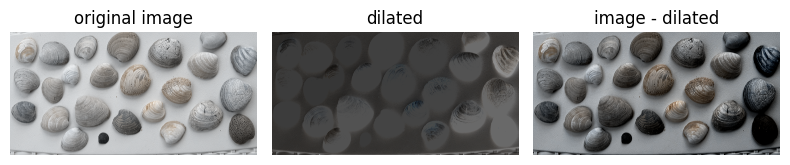

In [ ]:
# Clip the data to the valid range
image_clipped = np.clip(image, 0, 1)
dilated_clipped = np.clip(dilated, image.min(), image.max())
image_minus_dilated_clipped = np.clip(image - dilated, 0, 1)

# Create and configure subplots
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True)

# Display the original image
ax0.imshow(image_clipped, cmap='gray', vmin=0, vmax=1)
ax0.set_title('original image')
ax0.axis('off')

# Display the dilated image
ax1.imshow(dilated_clipped, cmap='gray', vmin=0, vmax=1)
ax1.set_title('dilated')
ax1.axis('off')

# Display the image minus dilated
ax2.imshow(image_minus_dilated_clipped, cmap='gray', vmin=0, vmax=1)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

According to the code, subtracting the dilated image leaves an image with just the coins and a
flat, black background, BUT this did not work for me.



The code included the following option, which I also tried:

Although the features (i.e. the clams) are clearly isolated, the clams
surrounded by a bright background in the original image are dimmer in the
subtracted image. We can attempt to correct this using a different seed
image.

Instead of creating a seed image with maxima along the image border, we can
use the features of the image itself to seed the reconstruction process.
Here, the seed image is the original image minus a fixed value, ``h``.



In [ ]:
# h-dome parameters
h = 0.4

# Apply reconstruction with h-dome on the inverted image
seed = image_inverted - h  # Seed is now based on h-dome
mask = image_inverted  # Using previously inverted image

dilated = reconstruction(seed, mask, method='dilation')

# Isolate dark features and invert back
hdome = image_inverted - dilated
isolated_features_hdome = invert(hdome)

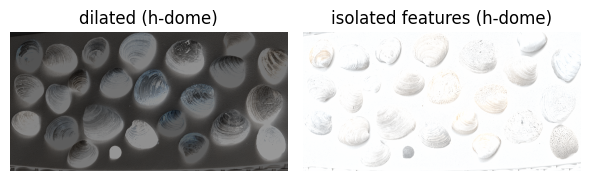

In [ ]:
# Create and configure subplots for h-dome result
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3),
                                sharex=True, sharey=True)

# Display the dilated image (from h-dome)
ax0.imshow(dilated, vmin=image_inverted.min(), vmax=image_inverted.max(), cmap='gray')
ax0.set_title('dilated (h-dome)')
ax0.axis('off')

# Display the isolated features (h-dome result)
ax1.imshow(0, cmap='gray')
ax1.set_title('isolated features (h-dome)')
ax1.axis('off')

fig.tight_layout()
plt.show()

To get a feel for the reconstruction process, we plot the intensity of the
mask, seed, and dilated images along a slice of the image (indicated by red
line).



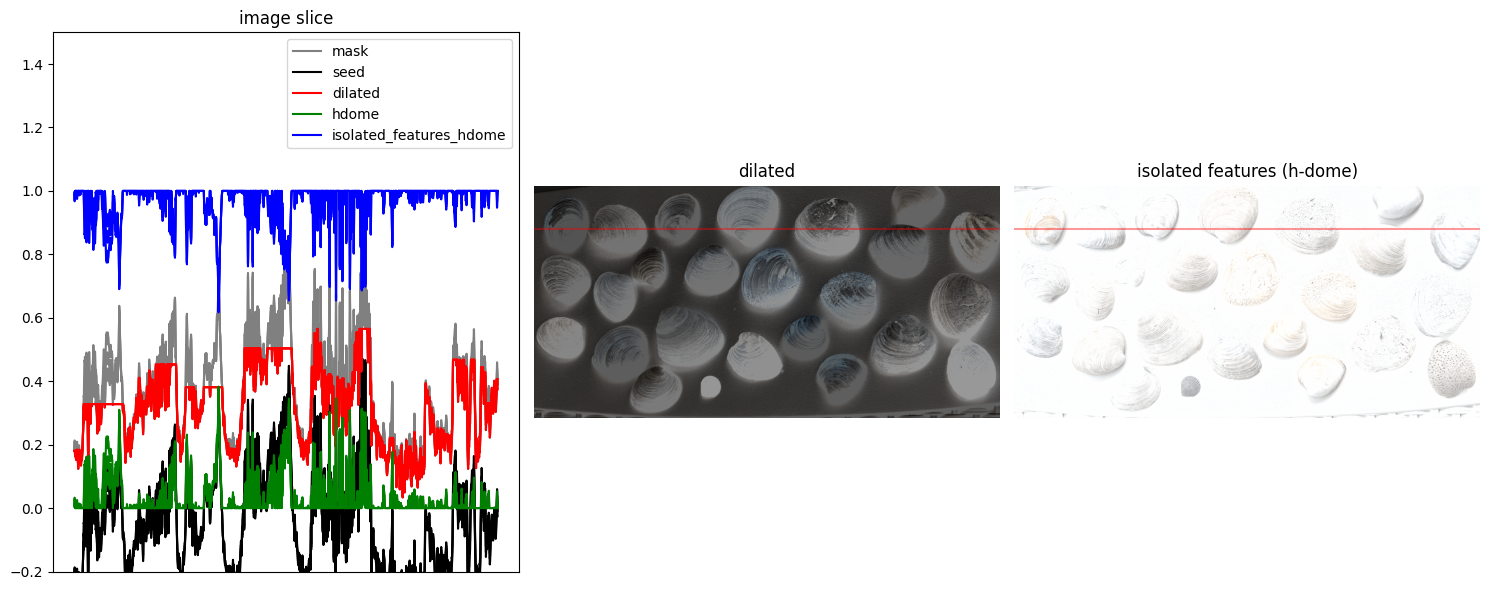

In [ ]:
# Create and configure subplots for h-dome visualization
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
yslice = 400  # You might need to adjust this based on your image

# Plot image slice
ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.plot(hdome[yslice], 'g', label='hdome')  # Add hdome line
ax0.plot(isolated_features_hdome[yslice], 'b', label='isolated_features_hdome')  # Add isolated_features_hdome line
ax0.set_ylim(-0.2, 1.5)  # Adjust if needed
ax0.set_title('image slice')
ax0.set_xticks([])

# Remove duplicate legend entries
handles, labels = ax0.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax0.legend(by_label.values(), by_label.keys())

# Display dilated image
ax1.imshow(dilated, vmin=image_inverted.min(), vmax=image_inverted.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

# Display isolated features (h-dome result)
ax2.imshow(isolated_features_hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('isolated features (h-dome)')
ax2.axis('off')

fig.tight_layout()
plt.show()

My adjustments to the code are above.  The code from the kit results are below:

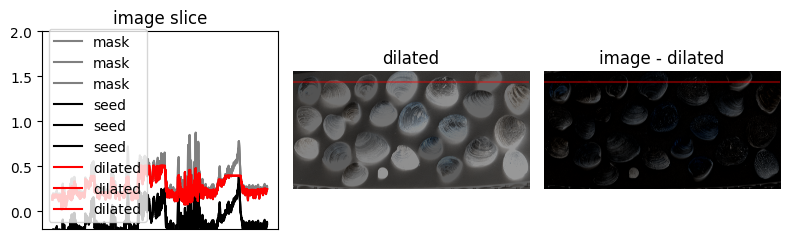

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

The authors explain:  As you can see in the image slice, each shell is given a different baseline
intensity in the reconstructed image; this is because we used the local
intensity (shifted by ``h``) as a seed value. As a result, the shell in the
subtracted image have similar pixel intensities. The final result is known
as the h-dome of an image since this tends to isolate regional maxima of
height ``h``. This operation is particularly useful when your images are
unevenly illuminated.

Overall I worked the most on this one, as I felt like it had the best potential implication for my usage of image classification.  I worked in a lot more code and improvements on this and was modestly please with the 5-lined image slice above.




# 4.0 Ridge operators

My first idea for this was to use an aerial image of a river system, like an anastamose stream in Alaska.  But I don't have any of those personally.  So I decided to see how it would work on banded minerals like Rhodochrosite.  This is an image from the Mines Museum that I took on a visit.

SOURCE INFO: Ridge filters can be used to detect ridge-like structures, such as neurites
[1]_, tubes [2]_, vessels [3]_, wrinkles [4]_ or rivers.

Different ridge filters may be suited for detecting different structures,
e.g., depending on contrast or noise level.

The present class of ridge filters relies on the eigenvalues of
the Hessian matrix of image intensities to detect ridge structures where the
intensity changes perpendicular but not along the structure.

## References

.. [1] Meijering, E., Jacob, M., Sarria, J. C., Steiner, P., Hirling, H.,
       Unser, M. (2004). Design and validation of a tool for neurite tracing
       and analysis in fluorescence microscopy images. Cytometry Part A, 58(2),
       167-176.
       :DOI:`10.1002/cyto.a.20022`

.. [2] Sato, Y., Nakajima, S., Shiraga, N., Atsumi, H., Yoshida, S.,
       Koller, T., ..., Kikinis, R. (1998). Three-dimensional multi-scale line
       filter for segmentation and visualization of curvilinear structures in
       medical images. Medical image analysis, 2(2), 143-168.
       :DOI:`10.1016/S1361-8415(98)80009-1`

.. [3] Frangi, A. F., Niessen, W. J., Vincken, K. L., & Viergever, M. A. (1998,
       October). Multiscale vessel enhancement filtering. In International
       Conference on Medical Image Computing and Computer-Assisted Intervention
       (pp. 130-137). Springer Berlin Heidelberg.
       :DOI:`10.1007/BFb0056195`

.. [4] Ng, C. C., Yap, M. H., Costen, N., & Li, B. (2014, November). Automatic
       wrinkle detection using hybrid Hessian filter. In Asian Conference on
       Computer Vision (pp. 609-622). Springer International Publishing.
       :DOI:`10.1007/978-3-319-16811-1_40`


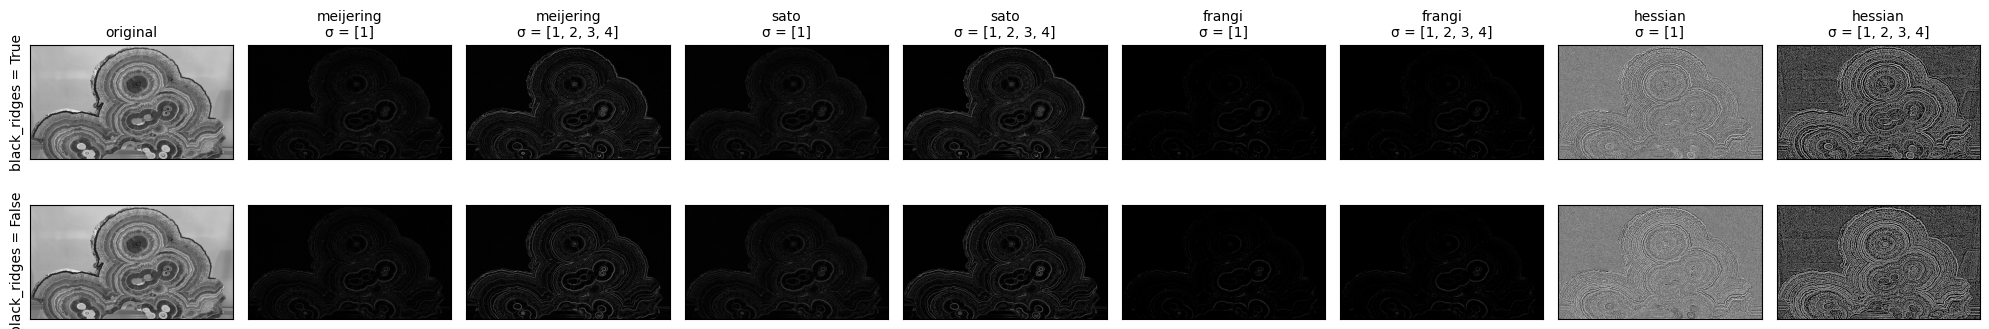

In [ ]:
def original(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


# Register the HEIC opener with Pillow to handle HEIC files
register_heif_opener()

# Load the HEIC image from Github
# This URL should point to the raw image file content:
image_url = 'https://raw.githubusercontent.com/RobinMikeal/Geol558/main/RHODOCHROSITE.heic'
response = requests.get(image_url)
response.raise_for_status() # Raise an exception for bad responses (like 404) to help debug
image = Image.open(BytesIO(response.content))

# Convert the image to grayscale
image = color.rgb2gray(np.array(image))

cmap = plt.cm.gray

plt.rcParams["axes.titlesize"] = "medium"
axes = plt.figure(figsize=(20, 4)).subplots(2, 9)
for i, black_ridges in enumerate([True, False]):
    for j, (func, sigmas) in enumerate(
        [
            (original, None),
            (meijering, [1]),
            (meijering, range(1, 5)),
            (sato, [1]),
            (sato, range(1, 5)),
            (frangi, [1]),
            (frangi, range(1, 5)),
            (hessian, [1]),
            (hessian, range(1, 5)),
        ]
    ):
        result = func(image, black_ridges=black_ridges, sigmas=sigmas)
        axes[i, j].imshow(result, cmap=cmap)
        if i == 0:
            title = func.__name__
            if sigmas:
                title += f"\n\N{GREEK SMALL LETTER SIGMA} = {list(sigmas)}"
            axes[i, j].set_title(title)
        if j == 0:
            axes[i, j].set_ylabel(f'{black_ridges = }')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

Overall, this was effective.  I am not quite sure of its application, but I think that it does have promise for evaluating mineral banding.  

#5.0 Region adjacency graph (RAG) Merging

For my last kit, I chose to use RAG merging of a coastal erosion/deposition system.  I thought it would be interesting to see how it handled the different textures in the geology, the vegetation, and the sky.

FROM SOURCE:This example constructs a Region Adjacency Graph (RAG) and progressively merges regions that are similar in color. Merging two adjacent regions produces a new region with all the pixels from the merged regions. Regions are merged until no highly similar region pairs remain.

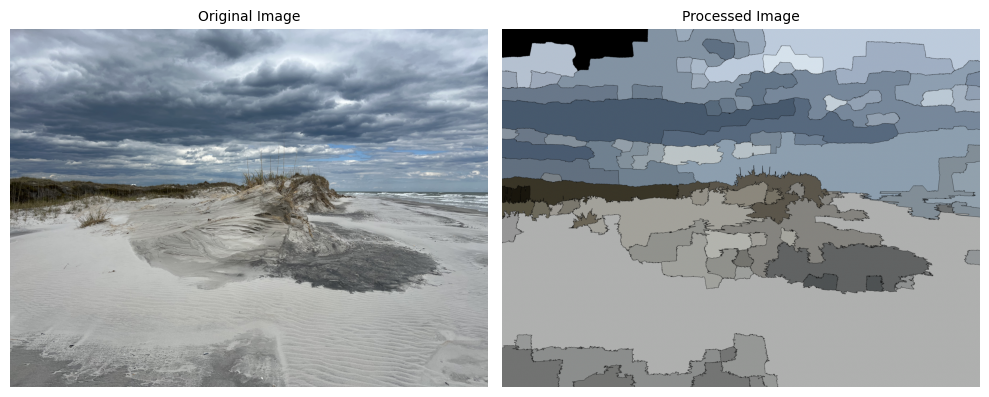

In [ ]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )


# Load the HEIC image from Github
register_heif_opener()  # Register HEIF opener
image_url = 'https://github.com/RobinMikeal/Geol558/blob/main/SANDCOASTAL.HEIC?raw=true'
response = requests.get(image_url)
img = np.array(Image.open(BytesIO(response.content)))

labels = segmentation.slic(img, compactness=30, n_segments=800, start_label=1)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(
    labels,
    g,
    thresh=25, #reduced from 35
    rag_copy=False,
    in_place_merge=True,
    merge_func=merge_mean_color,
    weight_func=_weight_mean_color,
)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))

# Display original and processed images side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(out)
ax2.set_title('Processed Image')
ax2.axis('off')

plt.tight_layout()
plt.show()

I played around with the number of segments (increasing from 400 to 800), and adjusted the thresh in order to capture the right amount of variation.  I think this could have implications on aerial/satellite images as well for evaluation of land use/land cover.  

# REFLECTION

The SciKit image gallery is filled with great ideas of different ways to use python to evaluate images.  I found that the Filtering Regional Maxima tool seemed most interesting and relevant to my studies for this semester.  For project 2, I worked many hours to try to remove the background of the mineral picture library that I was using.  When I saw this tool in the gallery, I was very excited.  However, upon implementing the tool on an image of shells which closely mimicked the sample image of coins, it really was not straight forward. I spent a lot of time still working on trying to get it to remove the background or at least lessen the effects of shadows and unequal lighting.  I looked up different ways to improve the h- and h-dome values to achieve the goal, but it still was not perfect.  It muted the shells so much; the detail was hard to distinguish.  I will likely continue to evaluate the image slice functions to see if there would be a way to remove background between spikes representing the shells.  It does not truly remove the background either for purposes of classification based on color. As I think about how I could have iterated through the mineral library, I don't think it would have been as useful as I had hoped and may take quite a bit of tweaking for each situation, dealing with shadows, unequal lighting, color casting, and transmission.  

 I was most surprised that the deconvolution did not clean up the underwater distortion better.  This is something that would be helpful in real-work video inspection of dams, if the clarity could be improved on underwater photos and images.    

 Overall, I believe each of these tools has potential and should be continued to be evaluated in my future study.
